In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
%matplotlib notebook

In [2]:
xmax = 20 #max x values in m
ymax = 20 #max y values in m
zmax = 20 #max z values in m
h = 1 #amount of space each point represents in m**3

In [3]:
space = np.zeros((xmax, ymax, zmax))

In [4]:
dv = 1
dr = (dv)**(1/3)

# Wind

In [5]:
def sun_e(space, eavg=1.08e7, estd=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *eavg*
            int average value of energy from sun in J/m**2/day;
            default = 1.08e7 (average over Chicago)
        *estd*
            int standard deviation of energy from sun from eavg;
            default = 1
    :Returns:
        *energies*
            numpy.array values of energy from sun in J/m**2/day using
            edist with mean eavg
    '''
    energies = np.zeros(space.shape)
    for i in range(np.array(space.shape)[0]):
        for j in range(np.array(space.shape)[1]):
            e = np.random.normal(loc=eavg, scale=estd)
            energies[i, j, -1] = e

    return energies

# Cloud

In [6]:
def cloud(space, loc=(10,10,10), size=(10,1,1), hcloud=1, hmed=.95, hair=.69):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            tuple location of center of cloud;
            default = (10,10,10)
        *size*
            tuple size of cloud;
            default = (10,1,1)
        *hcloud*
            int humidity of cloud;
            default = 1
        *hair*
            int humidity of air;
            default = 0
    :Returns:
        *humidities*
            numpy.array values of humidity
    '''
    assert all([i >= 0 for i in np.array(loc)-np.array(size)/2]) and \
    all([i >= 0 for i in np.array(space.shape)-np.array(loc)+np.array(size)/2]), \
    'Cloud must be within space.'

    humidities = space

    humidities[:][:][:] = hair

    n = np.array(size) % 2

    i = np.array(loc)[0]
    j = np.array(loc)[1]
    k = np.array(loc)[2]

    a0 = int(i-np.array(size)[0]/2)
    a1 = int(i+np.array(size)[0]/2) + n[0]
    b0 = int(j-np.array(size)[1]/2)
    b1 = int(j+np.array(size)[1]/2) + n[1]
    c0 = int(k-np.array(size)[2]/2)
    c1 = int(k+np.array(size)[2]/2) + n[2]

    humidities[a0-1:a1+1, b0-1:b1+1, c0-1:c1+1] = hmed
    humidities[a0:a1, b0:b1, c0:c1] = hcloud

    return humidities

# Tornado

In [7]:
def tornado(space, loc=10, lpress=10, rpress=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            int location of pressure difference;
            default = 10

    :Returns:
        *pressures*
            numpy.array values of pressure
    '''
    assert 0 < loc and loc < np.array(space.shape)[0], 'Pressure difference must be within space.'

    pressures = altitude_pressures(space)

    pressures[loc:, :, :] *= rpress

    pressures[:loc, :, :] *= lpress

    return pressures

# Algorithm: Wind

In [29]:
def energytopressure(energies, dV):
    ps = energies/dV
    return ps

In [9]:
def altitude_pressures(space):
    pressures = space
    for h in range(np.array(space.shape)[2]):
        p = 101325*np.e**(-0.000119806*h)
        pressures[:, :, h] = p
    return pressures

In [30]:
def calc_J_air(pressures, dV=dv, T=329):
    R = 8.314598
    js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                p = pressures[i, j, k]

                n = p*dV/(R*T)
                phi = n/dV

                try:
                    assert i-1 != -1
                    pleft = pressures[i-1, j, k]
                    n = pleft*dV/(R*T)
                    phileft = n/dV
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    pright = pressures[i+1, j, k]
                    n = pright*dv/(R*T)
                    phiright = n/dv
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    pfront = pressures[i, j-1, k]
                    n = pfront*dV/(R*T)
                    phifront = n/dV
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    pback = pressures[i, j+1, k]
                    n = pback*dV/(R*T)
                    phiback = n/dV
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    pdown = pressures[i, j, k-1]
                    n = pdown*dV/(R*T)
                    phidown = n/dV
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    pup = pressures[i, j, k+1]
                    n = pup*dV/(R*T)
                    phiup = n/dV
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                    gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = gradphi
                js[i, j, k, :] = J
    return js

In [31]:
js = calc_J_air(pressures)

In [33]:
pressures

array([[[   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901094.20800502],
        [   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901094.62539389],
        [   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901095.09647075],
        ..., 
        [   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901093.62562715],
        [   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901096.91881465],
        [   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.72726494,  10901095.08149469]],

       [[   101325.        ,    101312.8613842 ,    101300.7242226 , ...,
            101118.84118315,    101106.7272649

In [34]:
js

array([[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         ..., 
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,  -5.90875375e-04,  -1.52582144e-04, ...,
            2.95437687e-04,  -7.62910718e-05,   2.95437687e-04]],

        [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,

In [73]:
def pressure_diffusion(pressures, D=1.76e-5, dV=dv, T=329, dt=1):
    js = calc_J_air(pressures)
    R = 8.314598
    Rarray = R*np.ones(pressures.shape)
    ns = np.divide(pressures*dV, Rarray*T)

    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                a = js[i, j, k, 0]/4/D*np.random.normal(loc=1, scale=.2)
                b = js[i, j, k, 1]/4/D*np.random.normal(loc=1, scale=.2)
                c = js[i, j, k, 2]/4/D*np.random.normal(loc=1, scale=.2)
                d = js[i, j, k, 3]/4/D*np.random.normal(loc=1, scale=.2)
                e = js[i, j, k, 4]/4/D*np.random.normal(loc=1, scale=.2)
                f = js[i, j, k, 5]/4/D*np.random.normal(loc=1, scale=.2)

                if a < 0:
                    ns[i, j, k] += a
                    ns[i-1, j, k] -= a
                if b < 0:
                    ns[i, j, k] += b
                    ns[i+1, j, k] -= b

                if c < 0:
                    ns[i, j, k] += c
                    ns[i, j+1, k] -= c
                if d < 0:
                    ns[i, j, k] += d
                    ns[i, j-1, k] -= d

                if e < 0:
                    ns[i, j, k] += e
                    ns[i, j, k-1] -= e
                if f < 0:
                    ns[i, j, k] += f
                    ns[i, j, k+1] -= f

    pressures = ns*R*T/dV
    return pressures

In [74]:
def integrate_from_sun(space, dV=dv, tmax=20,
                       dt=1):
    pressures = np.zeros(space.shape)
    times = np.arange(0, tmax+1, dt)
    pt = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    ps = altitude_pressures(space)
    for t in times:
        pt[t] = ps
        energies = sun_e(space)
        ps += energytopressure(energies, dV)
        print(ps[:, 10, :])
        ps = pressure_diffusion(ps, dt)
    return pt

In [75]:
pt = integrate_from_sun(space)

[[   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977    101191.55517806
     101179.4325488     101167.31137181    101155.19164693
     101143.07337397    101130.95655277    101118.84118315
     101106.72726494  10901093.94776119]
 [   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977    101191.55517806
     101179.4325488     101167.31137181    101155.19164693
     101143.07337397    101130.95655277    101118.84118315
     101106.72726494  10901092.97533193]
 [   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977

[[   101333.75350606    101311.34184402    101301.17050556
     101283.32876351    101280.61764473    101262.02909918
     101251.83366321    101246.97315674    101221.83956289
     101217.87482499    101205.19193862    101188.3167924
     101183.50092522    101164.81254997    101158.93838347
     101137.68776795    101132.28800935    747710.90263919
   -9954944.85231974  41882028.27844987]
 [   101332.38805254    101310.3640844     101300.35596411
     101293.84748327    101273.22359253    101263.59662992
     101253.03641173    101236.88810931    101230.89304812
     101216.83141734    101199.04454673    101195.37451149
     101178.02094677    101166.8047953     101157.6831292
     101137.46944388    101134.53031033   1246863.40866523
  -13912567.77209428  45602371.54773076]
 [   101332.44525511    101311.97506274    101298.47546826
     101291.58157331    101273.52450256    101268.12190868
     101250.70284079    101241.73422139    101224.51548764
     101215.9168699     101204.5819

   -4.93550384e+04   3.73706789e+06  -2.34091313e+07   6.35773661e+07]]
[[  1.01352112e+05   1.01303570e+05   1.01310086e+05   1.01246451e+05
    1.01314530e+05   1.01244087e+05   1.01241603e+05   1.01300896e+05
    1.01170172e+05   1.01232342e+05   1.01218636e+05   1.01160289e+05
    1.01211648e+05   1.01140972e+05   1.01184987e+05   1.23923105e+05
   -8.80400504e+05   1.21443401e+07  -5.21457619e+07   9.45055205e+07]
 [  1.01354546e+05   1.01284973e+05   1.01299084e+05   1.01327482e+05
    1.01252038e+05   1.01256815e+05   1.01265409e+05   1.01206251e+05
    1.01263266e+05   1.01225061e+05   1.01157579e+05   1.01244920e+05
    1.01147531e+05   1.01171346e+05   1.01174636e+05   1.52977912e+05
   -1.64808226e+06   1.48077845e+07  -7.96594708e+07   1.20405540e+08]
 [  1.01345438e+05   1.01301816e+05   1.01295566e+05   1.01306022e+05
    1.01251471e+05   1.01303581e+05   1.01232205e+05   1.01262715e+05
    1.01193494e+05   1.01223244e+05   1.01213729e+05   1.01166885e+05
    1.01199406e+

[[  1.01369454e+05   1.01326749e+05   1.01383248e+05   1.00925899e+05
    1.01626670e+05   1.01121439e+05   1.01102561e+05   1.01851700e+05
    1.00660938e+05   1.01360323e+05   1.01421193e+05   1.00834470e+05
    1.01496257e+05   1.02425141e+05   4.47942655e+04   1.84676428e+06
   -1.74414086e+07   7.75072435e+07  -1.58387931e+08   1.84626758e+08]
 [  1.01470535e+05   1.01099798e+05   1.01254703e+05   1.01645543e+05
    1.01063240e+05   1.01192631e+05   1.01440964e+05   1.00788725e+05
    1.01679177e+05   1.01240404e+05   1.00708436e+05   1.01887265e+05
    1.00666476e+05   1.05854779e+05  -8.56170344e+04   3.44686200e+06
   -2.64957366e+07   1.38169240e+08  -4.01830395e+08   3.64489207e+08]
 [  1.01358646e+05   1.01259827e+05   1.01303188e+05   1.01386858e+05
    1.01022805e+05   1.01705511e+05   1.01007840e+05   1.01497586e+05
    1.00869897e+05   1.01302749e+05   1.01351157e+05   1.00874752e+05
    1.01385656e+05   1.05893161e+05  -6.11311108e+04   2.66800782e+06
   -1.48306419e+07

[[  1.01106540e+05   1.01991591e+05   1.02027358e+05   9.78761205e+04
    1.05244270e+05   9.99982916e+04   9.95576844e+04   1.06275131e+05
    9.53997427e+04   1.02835736e+05   1.03901575e+05   9.65668883e+04
    1.01854215e+05   1.91981446e+05  -2.53275213e+06   2.68263212e+07
   -1.02516357e+08   2.75956410e+08  -3.50528395e+08   2.36763783e+08]
 [  1.02441985e+05   9.94764270e+04   1.00764161e+05   1.04664271e+05
    9.89640397e+04   1.00616122e+05   1.03662301e+05   9.61085908e+04
    1.06998114e+05   1.00770735e+05   9.53125276e+04   1.10944329e+05
    7.84903577e+04   6.04761181e+05  -5.44139026e+06   5.20100093e+07
   -2.99990321e+08   1.11334841e+09  -2.64742161e+09   1.88928676e+09]
 [  1.01078187e+05   1.01032681e+05   1.01813027e+05   1.01609430e+05
    9.78278692e+04   1.05659842e+05   9.86820265e+04   1.04612165e+05
    9.75688303e+04   1.02478334e+05   1.03179646e+05   9.79064036e+04
    9.19338819e+04   4.75469988e+05  -5.19498249e+06   2.09129155e+07
   -1.57037929e+07

[[  8.52854637e+04   1.27626790e+05   1.39343879e+05  -7.93775384e+03
    2.17703814e+05   6.89855088e+04   3.22162097e+04   2.66026250e+05
   -7.71735499e+04   1.60412211e+05   2.01357241e+05  -2.61820762e+04
   -5.53250242e+05   1.35694601e+07  -8.08769283e+07   1.63172975e+08
   -3.13341735e+07  -5.42606932e+09   1.09961414e+10  -1.06252981e+10]
 [  1.35084746e+05   5.53144816e+04   4.76039218e+04   2.31977221e+05
    5.86840512e+03   6.44586214e+04   2.28923179e+05  -1.70851719e+05
    3.75219556e+05   4.07428159e+04  -1.34682783e+05   9.40956503e+05
   -6.79914652e+06   5.72974300e+07  -4.27758427e+08   2.63868740e+09
   -9.81888986e+09   3.89493342e+10  -7.42066728e+10   4.56006103e+10]
 [  8.84164926e+04   8.94554539e+04   1.62906671e+05   8.01577661e+04
    2.15929369e+04   2.60165345e+05  -4.20326542e+04   2.88019356e+05
   -6.74683384e+04   1.69076060e+05   1.65745202e+05   1.48457377e+05
   -2.62497387e+06   2.19457941e+07  -4.20415370e+07  -7.91153493e+08
    7.19179418e+09

[[ -9.45827802e+04   2.92294776e+05   6.34808401e+05  -1.15663039e+06
    1.20813706e+06  -2.12970783e+05  -7.92903721e+05   1.99973358e+06
   -1.82671380e+06   8.26702926e+05   1.51758912e+06  -2.41279102e+06
   -6.16455440e+06   6.47559170e+07   2.24328829e+08  -4.36437031e+09
    2.91948714e+10  -1.27892237e+11   2.03514427e+11  -1.21262952e+11]
 [  4.01369675e+05  -1.53271974e+05  -7.32963071e+05   1.56412807e+06
   -8.24502770e+05  -3.80627891e+05   1.88227507e+06  -3.21159034e+06
    3.09900827e+06  -6.08476535e+05  -3.76683231e+06   2.48815849e+07
   -1.45371092e+08   1.00966423e+09  -6.38567184e+09   2.98920522e+10
   -1.36807472e+11   4.44379387e+11  -7.75277081e+11   3.88961013e+11]
 [  2.13816819e+03  -2.17935160e+05   9.95904245e+05  -4.85247453e+05
   -6.92802938e+05   1.83440162e+06  -1.68948190e+06   2.69094094e+06
   -2.34617694e+06   1.15374154e+06   7.07884118e+05   2.28515959e+06
   -3.04410389e+07  -5.03022447e+07   2.31525539e+09  -2.24262630e+10
    1.34894473e+11

[[ -1.32968475e+06   1.10734106e+06   5.92861796e+06  -1.40916779e+07
    1.26875680e+07  -1.74558308e+06  -1.24952561e+07   2.36218878e+07
   -2.08713027e+07   8.49850025e+06   2.12700399e+07  -6.42836278e+07
    2.72582873e+08  -1.73127665e+09   2.33830433e+10  -1.07784411e+11
    5.21299247e+11  -1.48172788e+12   2.70268539e+12  -1.43315908e+12]
 [  2.34999410e+06   2.46789561e+04  -1.35342606e+07   1.91270757e+07
   -1.09590056e+07  -7.22832500e+06   2.40325129e+07  -4.07201744e+07
    3.86899528e+07  -8.05232751e+06  -8.32757696e+07   4.71012954e+08
   -2.96088516e+09   1.75830982e+10  -1.18862176e+11   5.37148915e+11
   -2.06452139e+12   4.73062204e+12  -7.85430786e+12   5.16346515e+12]
 [  1.18747895e+05  -5.46348502e+06   1.35699978e+07  -1.18505423e+07
   -9.01467419e+06   2.18689512e+07  -2.63335640e+07   3.66251987e+07
   -3.41680355e+07   1.67404904e+07   3.46554140e+06  -1.06594475e+07
    4.53210494e+08  -8.43253679e+09   7.97129554e+10  -4.98190188e+11
    2.32468387e+12

[[ -1.22496176e+07  -9.24296556e+06   9.78007070e+07  -1.65420545e+08
    1.41495138e+08  -1.06359395e+07  -1.64206606e+08   2.95590816e+08
   -2.82725193e+08   8.84461207e+07   4.18210815e+08  -1.87144418e+09
    9.06970147e+09  -9.22994422e+10   6.38308669e+11  -2.33766210e+12
    8.38077107e+12  -2.27067248e+13   2.79028470e+13  -1.64210340e+13]
 [  1.00905735e+07   2.98820556e+07  -2.27981936e+08   2.81008836e+08
   -1.52628512e+08  -8.68810823e+07   3.30648646e+08  -5.89979887e+08
    5.70079292e+08  -9.18093159e+07  -1.59882865e+09   9.46295671e+09
   -5.60967238e+10   3.62398143e+11  -2.05754560e+12   9.41166004e+12
   -3.34490862e+13   7.44938958e+13  -9.14064644e+13   5.31841999e+13]
 [  1.97124663e+07  -1.10422301e+08   2.43279650e+08  -2.17874335e+08
   -5.45043359e+07   2.68501458e+08  -4.10798951e+08   5.40271878e+08
   -4.96970398e+08   2.36688864e+08   1.67537565e+08  -2.30552095e+09
    3.02507894e+10  -2.31793852e+11   1.52027175e+12  -9.21823088e+12
    4.06823062e+13

[[ -2.71929351e+07  -3.15431038e+08   1.45731789e+09  -2.24170332e+09
    1.49409190e+09   4.63881368e+07  -1.98735676e+09   4.29777882e+09
   -4.04321632e+09   4.79431287e+08   7.62778555e+09  -3.40295505e+10
    2.82106409e+11  -2.12916086e+12   1.22020867e+13  -4.59988980e+13
    1.41049546e+14  -3.22936153e+14   3.81410423e+14  -2.01328661e+14]
 [ -1.46295258e+08   1.20289872e+09  -3.16673862e+09   4.31375788e+09
   -2.28629689e+09  -1.29474559e+09   5.03110919e+09  -9.12533221e+09
    8.40495411e+09  -3.50694358e+08  -2.95519223e+10   1.75897468e+11
   -9.04356388e+11   5.93690901e+12  -3.65680798e+13   1.52405147e+14
   -4.35233296e+14   9.95157048e+14  -1.25885672e+15   6.77551567e+14]
 [  5.76470664e+08  -2.22348336e+09   4.26868555e+09  -3.64732055e+09
    1.43026040e+08   3.52495194e+09  -5.70296486e+09   6.84421249e+09
   -7.41947446e+09   3.46514829e+09   1.01988409e+10  -1.15955363e+11
    1.01553602e+12  -5.72340665e+12   4.14127821e+13  -2.00202398e+14
    6.44045444e+14

In [76]:
pt[10, :, 10, :]

array([[  9.68283262e+04,   1.08686882e+05,   1.12942632e+05,
          6.62355440e+04,   1.34723016e+05,   8.91090892e+04,
          7.91446178e+04,   1.51917390e+05,   5.09841943e+04,
          1.18038380e+05,   1.28862098e+05,   5.18811296e+04,
         -7.48385638e+04,   3.17261666e+06,  -3.25212496e+07,
          1.48133840e+08,  -3.94258784e+08,  -2.58377441e+08,
          2.62087647e+09,  -2.11864606e+09],
       [  1.12959881e+05,   8.48843309e+04,   9.02715111e+04,
          1.38004599e+05,   7.29299991e+04,   9.20059547e+04,
          1.36826663e+05,   2.64234587e+04,   1.82276718e+05,
          9.03645680e+04,   3.41610390e+04,   2.81948349e+05,
         -1.11149982e+06,   1.20531078e+07,  -1.05511932e+08,
          7.34053279e+08,  -2.68147923e+09,   1.25284933e+10,
         -2.36088273e+10,   1.48018757e+10],
       [  9.79433379e+04,   9.87404496e+04,   1.14461274e+05,
          9.85592658e+04,   7.23765680e+04,   1.49995489e+05,
          6.74651586e+04,   1.44568397e+05

# Algorithm: Cloud

In [77]:
def calc_J_water(humidities, dV=dv, D=1.76e-5, T=329):
    js = np.zeros([np.array(humidities.shape)[0], np.array(humidities.shape)[1], np.array(humidities.shape)[2], 3])
    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                h = humidities[i, j, k]

                try:
                    assert i-1 != -1
                    hleft = humidities[i-1, j, k]
                    phileft = hleft
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    hright = humidities[i+1, j, k]
                    phiright = hright
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    hfront = humidities[i, j-1, k]
                    phifront = hfront
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    hback = humidities[i, j+1, k]
                    phiback = hback
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    hdown = humidities[i, j, k-1]
                    phidown = hdown
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    hup = humidities[i, j, k+1]
                    phiup = hup
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -D*gradphi
                js[i, j, k, :] = J
    return js

In [78]:
def water_diffusion(humidities, dV=dv, dt=1):
    js = calc_J_water(humidities)
    ns = humidities*dV

    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                if js[i, j, k, 0] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i+1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i-1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i-1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i+1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)

                if js[i, j, k, 1] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j+1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j-1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j-1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j+1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)

                if js[i, j, k, 2] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k+1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k-1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k-1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k+1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)

    humidities = ns/dV
    return humidities

In [79]:
def integrate_from_cloud(space, loc=(10, 10, 10), size=(5, 1, 1), dV=dv, tmax=20,
                       dt=1):
    humidities = np.zeros(space.shape)
    times = np.arange(0, tmax, dt)
    ht = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    hs = cloud(space, loc=loc, size=size)
    for t in times:
        ht[t] = hs
        hs = water_diffusion(hs, dt)
    return ht

In [80]:
integrate_from_cloud(space)

array([[[[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,

In [81]:
pt[t, x, y, z]

NameError: name 't' is not defined

In [ ]:
ht[t, x, y, z]

# Algorithm: Tornado

In [ ]:
xs, ys = np.meshgrid(np.arange(np.array(pt.shape)[0])*dr, np.arange(np.array(pt.shape)[2])*dr)
zs = pt[0,:,0,:]

In [ ]:
pt[1,:,10,:]

In [ ]:
def plot_surf(y_t, Dt=dr, Dx=dr, step=1, filename=None, offset=-1,
             elevation=40, azimuth=20, cmap=plt.cm.coolwarm):
    """Plot y_t as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    y_t : 2D array
          displacement y(t, x)
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    """
     
    t = np.arange(y_t.shape[0])
    x = np.arange(y_t.shape[1])
    T, X = np.meshgrid(t, x)
    Y = y_t.T[X, T]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X*Dx, T*Dt*step, Y, cmap=cmap, rstride=1, cstride=1, alpha=1)
    cset = ax.contourf(X*Dx, T*Dt*step, Y, 20, zdir='z', offset=offset+Y.min(), cmap=cmap)

    ax.set_ylabel(r'x position $x$ (m)')
    ax.set_xlabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    ax.set_zlim(offset + Y.min(), Y.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label('pressure')
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

def plot_y(y_t, Dx=dr, Dt=dr, step=1):
    X, Y = np.meshgrid(range(y_t.shape[0]), range(y_t.shape[1]))
    Z = y_t.T[Y, X]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(Y*Dx, X*Dt*step, Z)
    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    fig.tight_layout()
    return ax

<IPython.core.display.Javascript object>


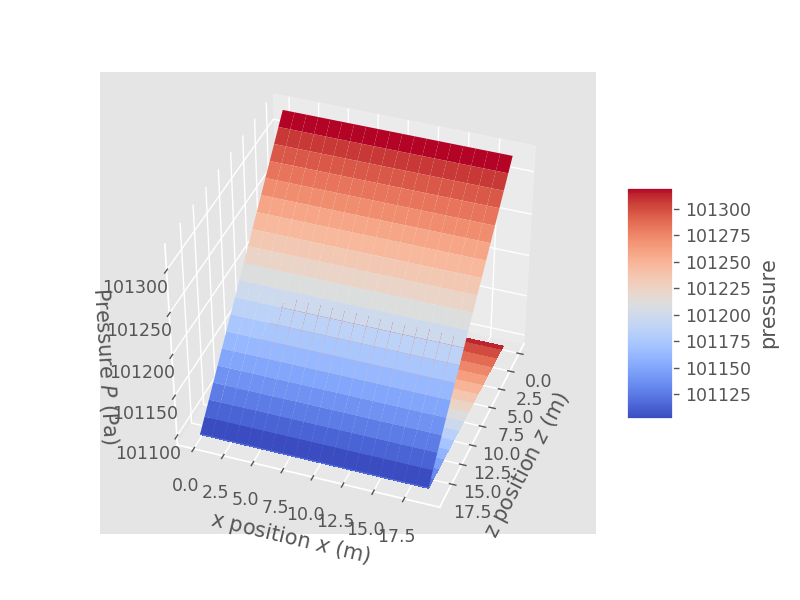

In [82]:
ax0 = plot_surf(pt[0,:,10,:])

<IPython.core.display.Javascript object>


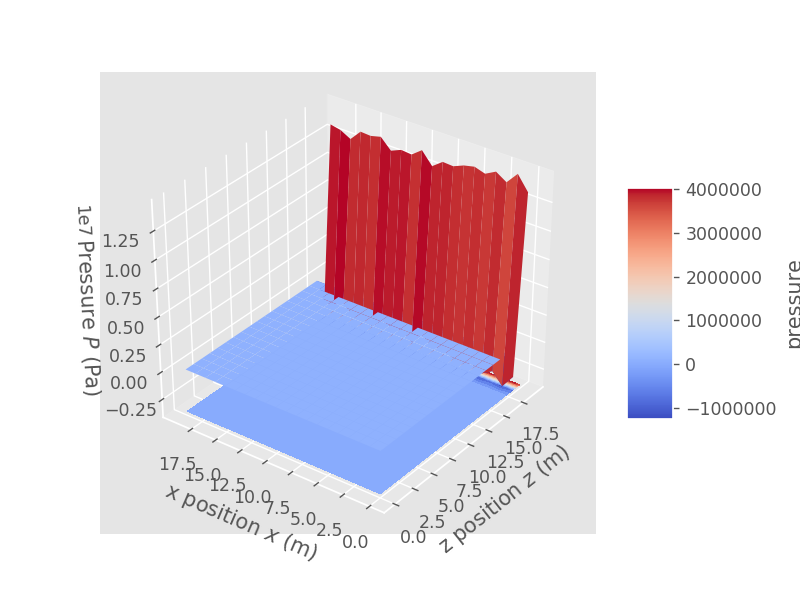

In [83]:
ax1 = plot_surf(pt[1,:,10,:])

<IPython.core.display.Javascript object>


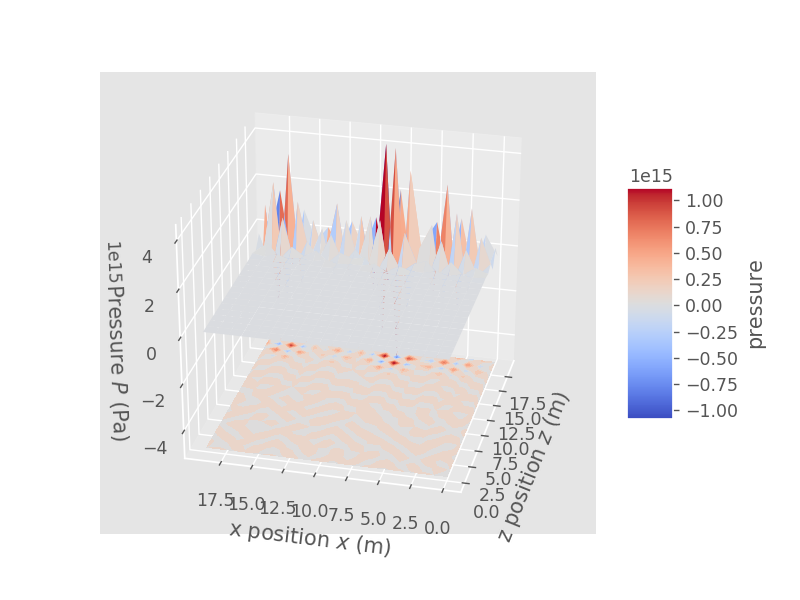

In [84]:
ax10 = plot_surf(pt[19,:,10,:])